In [5]:
import mysql.connector
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort

In [6]:
creds = pd.read_csv('/Users/gabrielabib/Desktop/NOVA_SBE/PBL/credentials.csv')

In [7]:
#Connection to the database
host = creds['Value'][0]
user = creds['Value'][1]
password = creds['Value'][2]
database = creds['Value'][3]
port = creds['Value'][4]
mydb = mysql.connector.connect(host=host, user=user, database=database, port=port, password=password, auth_plugin='mysql_native_password')
mycursor = mydb.cursor()
#Safecheck to guarantee that the connection worked
mycursor.execute('SHOW TABLES;')
print(f"Tables: {mycursor.fetchall()}")
print(mydb.connection_id) #it'll give connection_id,if got connected



Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',)]
802


In [8]:
alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)
#changing columns with date to a datetime
alertP1["DATA_ENVIO"] = pd.to_datetime(alertP1["DATA_ENVIO"],dayfirst=True, yearfirst=False )
alertP1["DATA_RECEPCAO"] = pd.to_datetime(alertP1["DATA_RECEPCAO"],dayfirst=True, yearfirst=False)
alertP1["DATA_RETORNO"] = pd.to_datetime(alertP1[alertP1["DATA_RETORNO"]!='26/06/0214']["DATA_RETORNO"],dayfirst=True, yearfirst=False)
alertP1["DATA_REALIZACAO"] = pd.to_datetime(alertP1["DATA_REALIZACAO"],dayfirst=True, yearfirst=False)
alertP1["DATA_MARCACAO"] = pd.to_datetime(alertP1["DATA_MARCACAO"],dayfirst=True, yearfirst=False)
#change the blank values in proveniencia to unknown
alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
#create a column with the output of a referral
alertP1['result']=['1' if x in [0,14,15,53,8,12,13] else '0' if x in [1,6,10,7] else '' for x in alertP1['COD_MOTIVO_RECUSA'] ]
#create a list with code of units inside area
area_list=[3150502,3151672,3150671,3150572,3150305,3150571,3151571,3151574,3150371,3151573,3150672,3152401,3150605,3152471,3151575,3151671,3151601,3150573,3151576,3150506,3150504,3152400,3150501,3150603,3151707,9999999,3152403,3151400,3152100,3151401,4021100,4021104,3152002]
#create a column with area of the unit
alertP1['area']=['inside area' if x in area_list else 'outside area' for x in alertP1['COD_UNID_SAUDE_PROV'] ]
#compute length of text
alertP1['text_length']=alertP1['Texto'].str.len()
#step of referral(first or second or ..)
alertP1['step']=alertP1.sort_values(by=['DATA_RECEPCAO']).groupby('ID_DOENTE').cumcount()+1
#speciality 
alertP1['speciality_type'] = ['General Neurology' if x == 'NEUROLOGIA' else 'Other specialities'  for x in alertP1['DES_ESPECIALIDADE']]

alertP1.head()

/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/var/folders/g5/43zxmsfs73v6lgj3_2k04qj80000gp/T/ipykernel_3141/515315357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/var/folders/g5/43zxmsfs73v6lgj3_2k04qj80000gp/T/ipykernel_3141/515315357.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PR

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,PROVENIENCIA,COD_CTH_PRIOR,CTH_PRIOR,...,trata data recusa,resume saída,mês_saida,ano_saida,Texto,result,area,text_length,step,speciality_type
0,SSHCCB,LVMVDV,LQHSOQLH,GDCADAB,3151575,USF TORRE DA MARINHA,CS/USF,CTH,3,Normal,...,21/05/2015,12/06/2015,6,2015,"Utente de 75 anos, refere tremor desde há 5 an...",1,inside area,701,1,General Neurology
1,CSAS,LVMVBD,LOHLTRTS,FZFZSDB,3152471,USF SERVIR SAUDE-CS,CS/USF,CTH,,unknown,...,23/04/2012,02/07/2012,7,2012,Avaliação neurologica para avaliação da toma d...,1,inside area,363,1,General Neurology
2,ADCFD,LVMMVJ,LQHROQHL,,0,,OUTRA,SAM,,unknown,...,26/09/2014,13/01/2015,1,2015,cefaleias,1,outside area,9,1,Other specialities
3,SSZDBZ,LVMMLV,LPHQULSU,CSGGHEZ,3151672,USF AMORA SAUDAVEL,CS/USF,CTH,,unknown,...,25/10/2013,03/12/2013,12,2013,"Utente do sexo feminino com 30 anos de idade, ...",1,inside area,417,1,General Neurology
4,SEAHEG,LVMNDL,LPHHVHVL,,0,,OUTRA,unknown,,unknown,...,26/02/2013,26/02/2013,2,2013,Sem relatorio clinico,0,outside area,22,1,General Neurology


In [9]:
accepted=alertP1[alertP1['result']=='1']['ID_DOENTE'].groupby(alertP1['step']).count().reset_index().rename(columns={"ID_DOENTE":"number_of_acceptance"})

total_referrals = alertP1['ID_DOENTE'].groupby(alertP1['step']).count().reset_index().rename(columns={"ID_DOENTE":"number_of_referrals"})
total_referrals
#divide the number of referrals for each specialty and priority level by the total number of referrals for that specialty, then multiply by 100 to get the percentage
accepted['percentage'] = round(accepted['number_of_acceptance'] / total_referrals['number_of_referrals'] * 100)
accepted

,step,number_of_acceptance,percentage
0,1,4985,61.0
1,2,1029,66.0
2,3,192,64.0
3,4,38,57.0
4,5,6,35.0
5,6,4,57.0


In [10]:
#converting categorical features
data=alertP1.copy()
data=data[data['result']!='']
area = pd.get_dummies(data['area'],drop_first=True)
Provenance = pd.get_dummies(data['PROVENIENCIA'],drop_first=True)
speciality_type = pd.get_dummies(data['speciality_type'],drop_first=True)
step= pd.get_dummies(data['step'],drop_first=True)
data.drop(['area','PROVENIENCIA','speciality_type','step'],axis=1,inplace=True)
data = pd.concat([data,area,Provenance,speciality_type,step],axis=1)
data
#cross tab

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,SAM,SON,unknown,Other specialities,2,3,4,5,6,7
0,SSHCCB,LVMVDV,LQHSOQLH,GDCADAB,3151575,USF TORRE DA MARINHA,CS/USF,3,Normal,0,...,0,0,0,0,0,0,0,0,0,0
1,CSAS,LVMVBD,LOHLTRTS,FZFZSDB,3152471,USF SERVIR SAUDE-CS,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,0,0,0
2,ADCFD,LVMMVJ,LQHROQHL,,0,,OUTRA,,unknown,0,...,1,0,0,1,0,0,0,0,0,0
3,SSZDBZ,LVMMLV,LPHQULSU,CSGGHEZ,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,0,0,0
4,SEAHEG,LVMNDL,LPHHVHVL,,0,,OUTRA,,unknown,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10144,GSHADS,,LSHRSQTV,ZDCECBSE,9999999,UNIDADE ALERT-P,CS/USF,,unknown,7,...,0,0,0,0,0,0,0,0,0,0
10146,GSFFSC,,LSHTPHVS,ZEHGFBSH,3151104,MIGUEL BOMBARDA,CS/USF,,unknown,7,...,0,0,0,0,0,0,0,0,0,0
10147,GSCHDB,,LSHTVPOP,,0,,OUTRA,,unknown,1,...,1,0,0,0,0,0,0,0,0,0
10148,GSBZAA,,LSHUQOPP,ZEESAADG,3151101,ALHOS VEDROS,CS/USF,,unknown,7,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# import the class
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#split dataset in features and target variable// Question: is it the right option?
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
clf=logreg.fit(X_train, y_train)
print(clf.coef_, clf.intercept_)
y_pred = logreg.predict(X_test)

X

[[ 6.17402627e-04 -3.36772586e-01 -7.03949102e-01 -2.24510280e+00
  -1.75121330e+00  3.49499189e+00  4.57209530e-01  4.38687551e-01
   2.04309868e-01 -7.01908058e-02  5.84951936e-02 -8.09740458e-02]] [1.05458582]


/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'st

,text_length,outside area,SAM,SON,unknown,Other specialities,2,3,4,5,6,7
0,701,0,0,0,0,0,0,0,0,0,0,0
1,363,0,0,0,0,0,0,0,0,0,0,0
2,9,1,1,0,0,1,0,0,0,0,0,0
3,417,0,0,0,0,0,0,0,0,0,0,0
4,22,1,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10144,0,0,0,0,0,0,0,0,0,0,0,0
10146,0,1,0,0,0,0,0,0,0,0,0,0
10147,0,1,1,0,0,0,0,0,0,0,0,0
10148,0,1,0,0,0,0,0,0,0,0,0,0


In [12]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 164,  414],
       [  71, 1203]])

Text(0.5, 257.44, 'Predicted label')

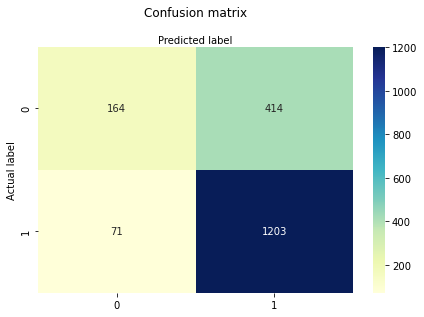

In [13]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

Accuracy: 0.7381209503239741
Recall: 0.6140035199600202


In [15]:
#p value 

In [16]:
from sklearn.metrics import classification_report
target_names = ['accepted', 'refused']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    accepted       0.70      0.28      0.40       578
     refused       0.74      0.94      0.83      1274

    accuracy                           0.74      1852
   macro avg       0.72      0.61      0.62      1852
weighted avg       0.73      0.74      0.70      1852



In [28]:
features = list(X.columns)

/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/gabrielabib/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.7489200863930886
Recall: 0.6269476993233899


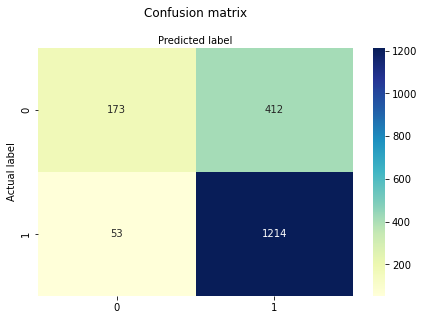

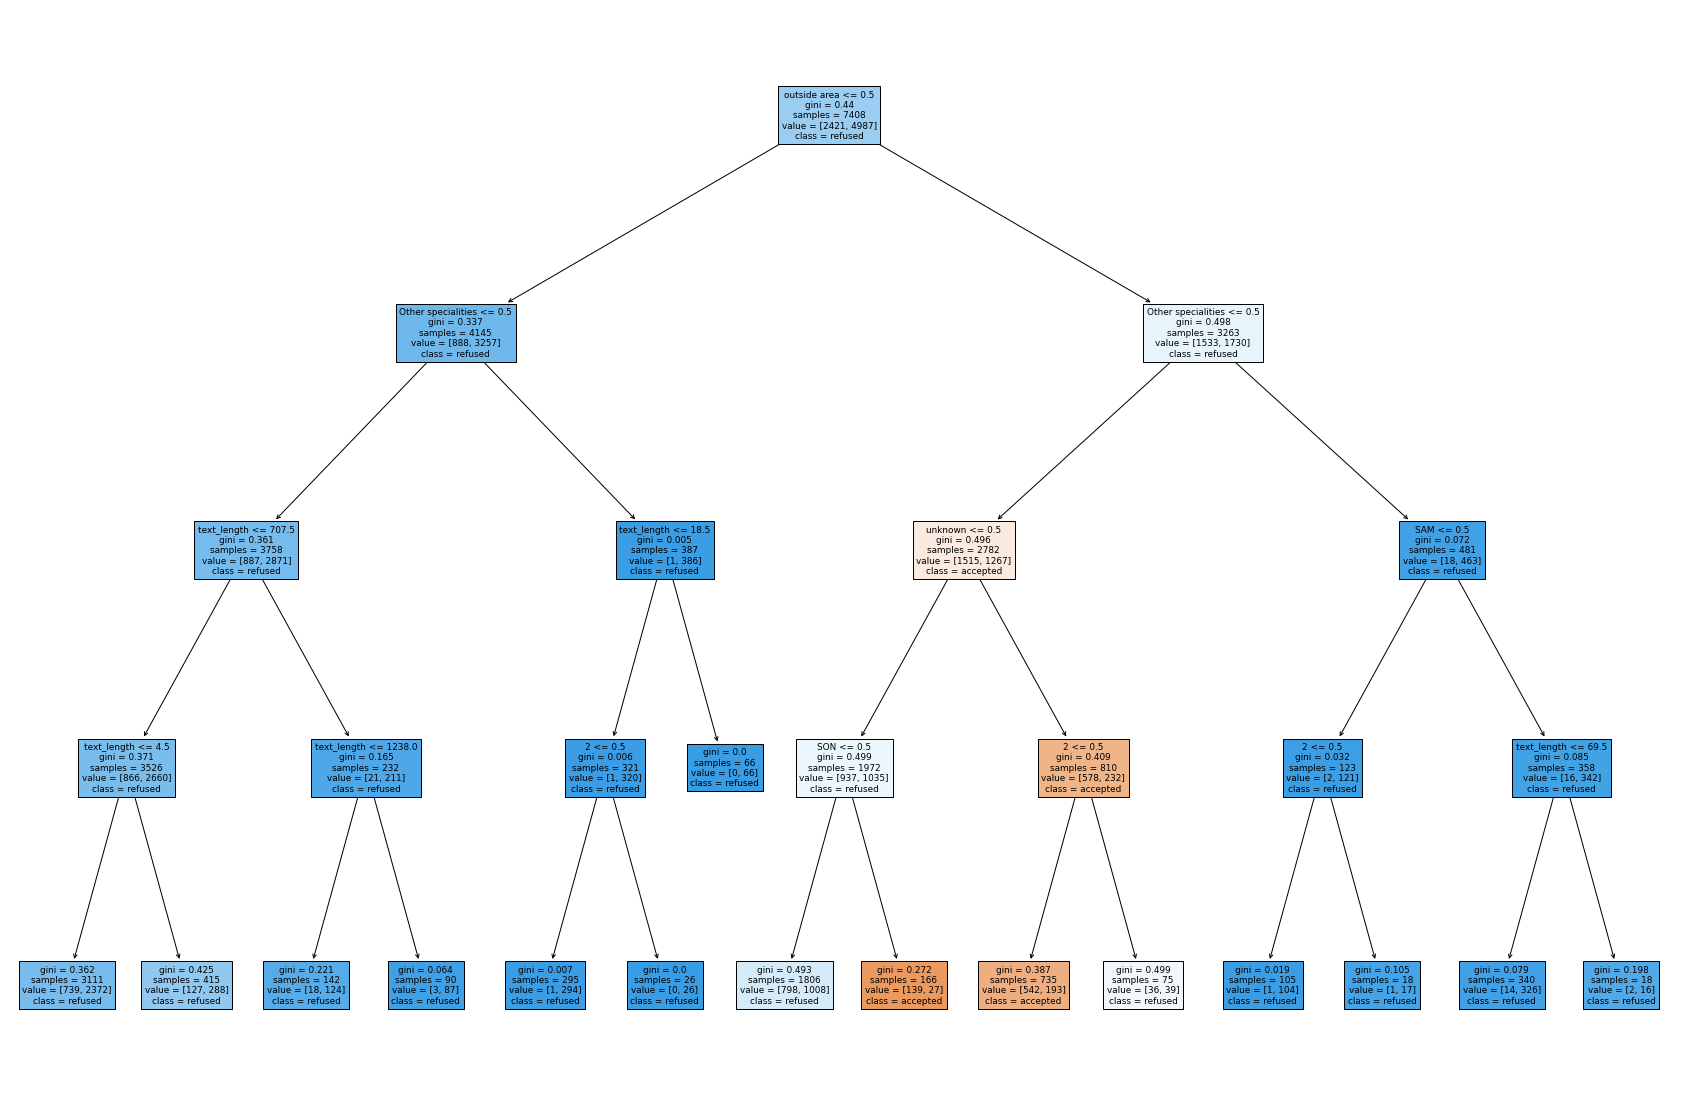

              precision    recall  f1-score   support

    accepted       0.77      0.30      0.43       585
     refused       0.75      0.96      0.84      1267

    accuracy                           0.75      1852
   macro avg       0.76      0.63      0.63      1852
weighted avg       0.75      0.75      0.71      1852



In [34]:
# Decision Tree classification model

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report

#split dataset in features and target variable
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable

# feature_cols = ['text_length','outside area','SAM','SON','unknown','Other specialities']
# X = data[feature_cols] # Features
# y = data.result # Target variable

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['accepted', 'refused'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['accepted', 'refused']
print(classification_report(y_test, y_pred, target_names=target_names))